# Fast Food Marketing Campaign Analysis

### About
A fast-food chain is planning to add a new item to the menu, but before fully rolling out the item, the company wants to experiment with three different campaigns promoting the new item at restaurants in randomly selected markets. The idea is to see which promotion works best at bringing in sales, which is reported on a weekly basis over a 4 week period.

## Hypothesis

With three different promotions being tested, the goal is to measure the sales behind each promotion and determine whether there is a statistically significant difference in sales between the three promotions. That being said, the null and alternate hypothesis are as follows:

**Null**: There is no statistically significant difference in sales between the the three promotions.

**Alternate**: There is a statistically significant difference in sales between the three promotions.

### Importing Packages/Loading Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import warnings

import scipy.stats as stats
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r'Downloads\WA_Marketing-Campaign.csv')

In [3]:
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


## Understanding the Data

#### How many restaurants are involved in the campaign?

In [5]:
print('There are', df['LocationID'].nunique(), 'stores involved in the campaign')

There are 137 stores involved in the campaign


#### How many weeks is the campaign running for?

In [6]:
print('The campaign is running for', df['week'].max(),'weeks')

The campaign is running for 4 weeks


#### How many restaurants are in each market?

In [7]:
market_counts = pd.DataFrame(df.groupby(['MarketID'])['LocationID'].count().reset_index())

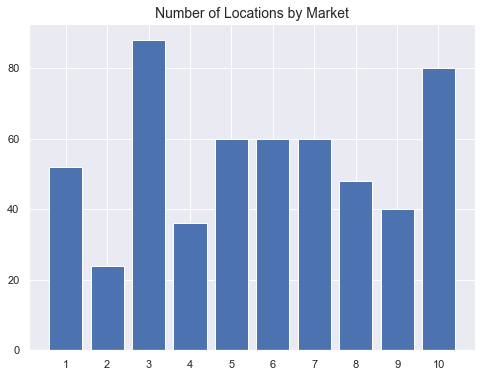

In [8]:
fig = plt.figure(figsize=(8,6))
plt.bar(market_counts['MarketID'], market_counts['LocationID'])
plt.xticks(market_counts['MarketID'])
plt.title('Number of Locations by Market', fontsize = 14)
plt.show()

## Checking for Pretest Bias

### Promotions by Market Size
Are the promotions evenly distributed across the different market sizes?

In [9]:
promotion_market = pd.DataFrame(df.groupby(['Promotion','MarketSize'])['LocationID'].nunique().unstack())

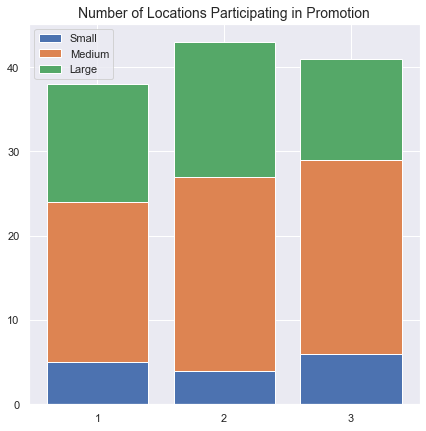

In [10]:
fig = plt.figure(figsize=(7,7))
plt.bar(['1','2','3'], promotion_market.Small, label = 'Small')
plt.bar(['1','2','3'], promotion_market.Medium, bottom=promotion_market.Small, label = 'Medium')
plt.bar(['1','2','3'], promotion_market.Large, bottom=promotion_market.Medium, label = 'Large')
plt.legend()
plt.xticks(rotation=0, ha='center')
plt.title('Number of Locations Participating in Promotion', fontsize = 14)
plt.show()

While Promotion 2 is more commonly rolled out than the other two, each promotion is most commonly being tested in medium sized markets.

### Average Store Age by Promotion

In [11]:
store_age = pd.DataFrame(df.groupby('Promotion')['AgeOfStore'].mean().round(2))

In [12]:
store_age

,AgeOfStore
Promotion,
1,8.28
2,7.98
3,9.23


The average store age appears to be between 8-9 years old, so no imbalance here.

## Understanding the Target Variable: Sales

In [13]:
print('The average weekly restaurant sales during the 4 week campaign is',round(df['SalesInThousands'].mean(),2),'thousand')

The average weekly restaurant sales during the 4 week campaign is 53.47 thousand


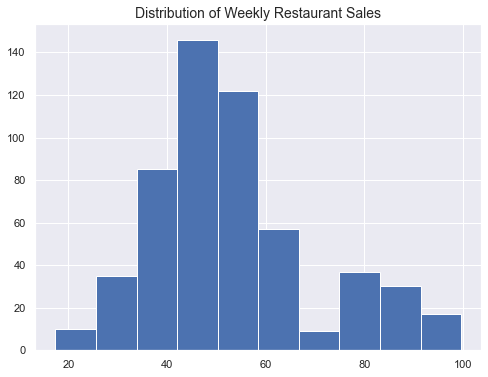

In [14]:
fig = plt.figure(figsize=(8,6))
plt.hist(df['SalesInThousands'])
plt.title('Distribution of Weekly Restaurant Sales', fontsize = 14)
plt.show()

### Weekly Sales by Promotion

In [15]:
sales = pd.DataFrame(df.groupby(['Promotion','week'])['SalesInThousands'].sum().reset_index())
weekly_sales = sales.pivot('week','Promotion','SalesInThousands')

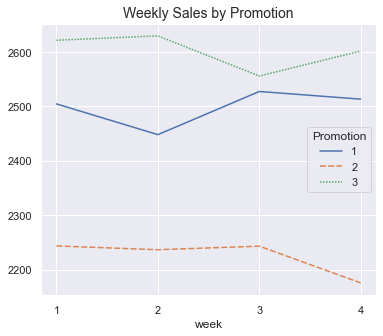

In [16]:
fig = plt.figure(figsize=(6,5))
sns.lineplot(data=weekly_sales)
plt.title('Weekly Sales by Promotion', fontsize = 14)
plt.xticks([1,2,3,4])
plt.show()

### Running Sum of Sales by Promotion

In [17]:
weekly_sales_cumulative = sales.pivot('week','Promotion','SalesInThousands').cumsum()

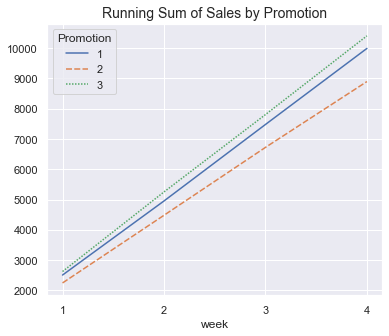

In [18]:
fig = plt.figure(figsize=(6,5))
sns.lineplot(data=weekly_sales_cumulative)
plt.title('Running Sum of Sales by Promotion', fontsize = 14)
plt.xticks([1,2,3,4])
plt.show()

**Thoughts**

It's clear that Promotions 3 and 1 have the most sales, with Promotion 2 having the least sales. Just comparing the sales figures is not enough however, as we need to determine whether these differences are statistically significant. We can start exploring this through a one-way ANOVA test.

## One-Way ANOVA Test

In [19]:
# Creating series for sales of each promotion
promo_1 = df[df['Promotion'] == 1]['SalesInThousands']
promo_2 = df[df['Promotion'] == 2]['SalesInThousands']
promo_3 = df[df['Promotion'] == 3]['SalesInThousands']

In [20]:
# Performing the ANOVA
stats.f_oneway(promo_1, promo_2, promo_3)

F_onewayResult(statistic=21.953485793080677, pvalue=6.765849261408714e-10)

**Results**

The ANOVA test yields an F-statistic of 21.95 and a p-value that is much lower than an alpha value of 0.05 or 0.01, indicating that there is an statistically significant difference in the mean sales between the three promotions.  

## Post-Hoc Testing
Which promotion's sales is causing the statistically significant difference in sales? We can use Tukey's test to tell us which differences and significant.

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-10.7696,0.001,-14.774,-6.7652,True
1,3,-2.7345,0.2447,-6.7389,1.2698,False
2,3,8.0351,0.001,4.1207,11.9494,True


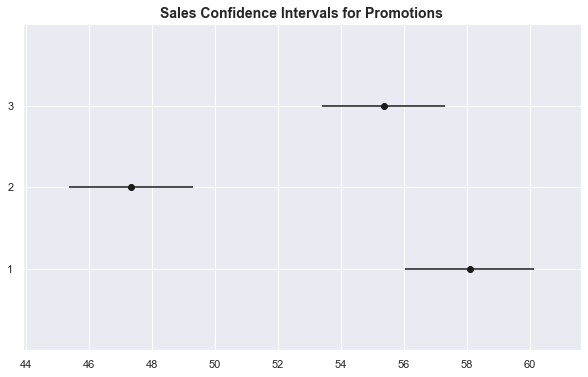

In [21]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df['SalesInThousands'],
                         groups = df['Promotion'],
                         alpha = 0.05)

tukey.plot_simultaneous()
plt.title('Sales Confidence Intervals for Promotions', fontsize=14, fontweight='bold')
tukey.summary()

**Thoughts**

The Tukey test summary table show us the mean difference in sales, the p-values, and whether we can accept (True) or reject (False) the null hypothesis. 

The results show that there is a statistically significant difference between promotions **1 and 2** and between **2 and 3**, while there is not a statistically significant difference between promotions 1 and 3.

## Recommendations

Promotions 1 and 3 both outperform promotion 2, so we wouldn't recommend promotion 2. Because the mean sales for promotions 1 and 3 are so close together, we can't confidently recommend one over the other. Below are some recommendations to consider:
- Roll out both promotion 2 and 3.
- Compare and contrast the elements of promotion 2 and 3 to devise a new promotion that combines the best elements of both into one.
- Make this a true A/B test. Measure sales at restaurants where the new item has not been added to the menu as part of a control group, and then rollout just one promotion at select restaurants. Sales can be measured pre-test and during the test to determine the impact on sales and whether there is a statistically significant difference or not.

## Ideas for Additional Data
- Demographic info on the markets these restaurants are in
- More granular sales reporting
    - Sales for both the new item introduced and overall restaurant sales
    - What percentage of sales for the new item came in-store vs. drive-thru?
    - What other food/drink items were commonly purchased along with the new item?
- What other food/drink items were commonly purchased along with the new item?
- An indication of whether there are any other ongoing promotions running concurrently at these restaurants.